# Development of machine learning models to process Electronic Health Records – Explainable Models

### Preprocessing Notebook
Lok Hang Toby Lee (2431180L)

# Machine Learning
--------------------------------------------

In [80]:
# Imports:
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, train_test_split
from matplotlib import pyplot as plt
import seaborn as sn
import sys
sys.path.append('../')
#from plot_metrics import PlotMetrics
import tensorflow as tf
import imp
import warnings
warnings.filterwarnings('ignore')

# SET YOUR PATH FOR RESOURCES FILE HERE
resources_path = "E:/MIMIC-III-ML/Workspace/resources/"
data_path = "E:/MIMIC-III-ML/Workspace/data/"

In [81]:
# Extract the in-hospital mortality data:
X = pd.read_hdf(data_path + 'vitals_hourly_data_preprocessed.h5', 'X')
Y = pd.read_hdf(data_path + 'vitals_hourly_data_preprocessed.h5', 'Y')[['in_hospital_mortality', 'los']]

X = X.sort_index(axis = 0, level = 'icustay_id')
Y = Y.sort_index(axis = 0, level = 'icustay_id')

# Remove the icustays that were less than 48 hours:
indices_to_remove = []
for i, row in Y.iterrows():
    if row['los'] < 48:
        indices_to_remove.append(i)
        
X = X.reset_index().set_index('icustay_id').drop(indices_to_remove, axis = 0)
Y = Y.drop(indices_to_remove, axis = 0)

In [82]:
patients_data = X

patients_data['in_hospital_mortality']= Y['in_hospital_mortality']
patients_data['los']= Y['los']
patients_data.to_csv(data_path + 'final_data.csv')

patients_data.columns


Index(['subject_id', 'hadm_id', 'hours_in', 'Diastolic blood pressure',
       'Diastolic blood pressure1', 'Fraction inspired oxygen',
       'Fraction inspired oxygen1', 'Glucose', 'Glucose1', 'Heart Rate',
       'Heart Rate1', 'Height', 'Height1', 'Mean blood pressure',
       'Mean blood pressure1', 'Oxygen saturation', 'Oxygen saturation1',
       'Respiratory rate', 'Respiratory rate1', 'Systolic blood pressure',
       'Systolic blood pressure1', 'Temperature', 'Temperature1', 'Weight',
       'Weight1', 'pH', 'pH1', 'Diastolic blood pressure2',
       'Fraction inspired oxygen2', 'Glucose2', 'Heart Rate2', 'Height2',
       'Mean blood pressure2', 'Oxygen saturation2', 'Respiratory rate2',
       'Systolic blood pressure2', 'Temperature2', 'Weight2', 'pH2',
       'in_hospital_mortality', 'los'],
      dtype='object')

In [83]:
patients_data

,subject_id,hadm_id,hours_in,Diastolic blood pressure,Diastolic blood pressure1,Fraction inspired oxygen,Fraction inspired oxygen1,Glucose,Glucose1,Heart Rate,...,Height2,Mean blood pressure2,Oxygen saturation2,Respiratory rate2,Systolic blood pressure2,Temperature2,Weight2,pH2,in_hospital_mortality,los
icustay_id,,,,,,,,,,,,,,,,,,,,,
200003,27513,163557,0,1.0,NaN,0.0,NaN,1.0,NaN,1.0,...,-0.999068,-0.137486,-0.147118,-0.137439,-0.133019,-0.313701,-0.681936,-0.730732,0,141.3216
200003,27513,163557,1,1.0,NaN,0.0,NaN,0.0,NaN,1.0,...,-0.999068,-0.137486,-0.147118,-0.137439,-0.133019,-0.313701,-0.681936,-0.730732,0,141.3216
200003,27513,163557,2,1.0,NaN,0.0,NaN,0.0,NaN,1.0,...,-0.999068,-0.137486,-0.147118,-0.137439,-0.133019,-0.313701,-0.681936,-0.730732,0,141.3216
200003,27513,163557,3,1.0,NaN,0.0,NaN,0.0,NaN,1.0,...,-0.999068,-0.137486,-0.147118,-0.137439,-0.133019,-0.313701,-0.681936,-0.730732,0,141.3216
200003,27513,163557,4,1.0,NaN,0.0,NaN,0.0,NaN,1.0,...,-0.999068,-0.137486,-0.147118,-0.137439,-0.133019,-0.313701,-0.681936,-0.730732,0,141.3216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,28775,134959,44,0.0,NaN,0.0,NaN,0.0,NaN,1.0,...,1.432676,-0.024036,0.658704,-0.137439,-0.018720,0.271422,0.497373,0.005969,0,48.3216
299995,28775,134959,45,0.0,NaN,0.0,NaN,0.0,NaN,1.0,...,1.436226,0.089414,0.793008,-0.137439,0.095580,0.368943,0.529246,0.027017,0,48.3216
299995,28775,134959,46,1.0,NaN,0.0,NaN,0.0,NaN,1.0,...,1.439776,-0.137486,0.927311,-0.137439,-0.133019,-0.313701,0.561119,0.048066,0,48.3216


### Machine Learning Base model

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold, train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot

def showResults(test, pred, model_name):
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score_macro = f1_score(test, pred, average='macro') 
    f1score_micro = f1_score(test, pred, average='micro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score macro : {}".format(f1score_macro))
    print("f1score micro : {}".format(f1score_micro))
    cm=confusion_matrix(test, pred, labels=[1,2,3,4,5,6,7,8])
    # return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score_macro,3), 
    #         round(f1score_micro, 3), cm)

### Logistic Regression (train test split)

Logistic Regression:
Accuracy  : 0.4755775281419239
Precision : 0.5435908165185924
Recall : 0.5865857266510439
f1score macro : 0.43575911673076984
f1score micro : 0.4755775281419239


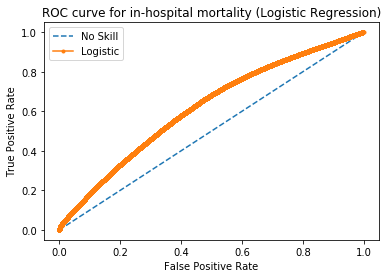

Text(0.5, 1, 'Confusion matrix for in-hospital mortality (Logistic Regression)')

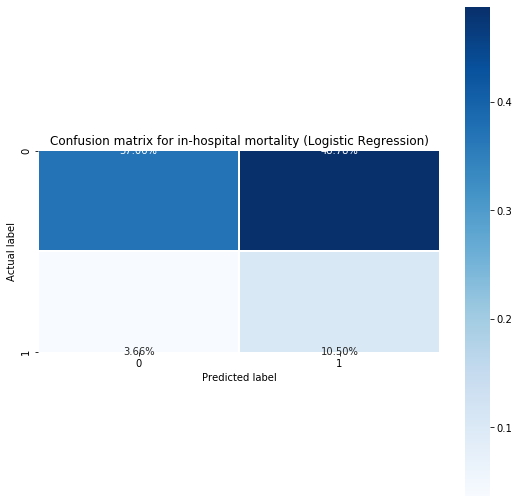

In [85]:
df_train, df_test = train_test_split(patients_data, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 100)

numeric_vars = ['Diastolic blood pressure2','Fraction inspired oxygen2', 'Glucose2', 'Heart Rate2', 'Height2', 'Mean blood pressure2', 'Oxygen saturation2', 'Respiratory rate2', 'Systolic blood pressure2', 'Temperature2', 'Weight2', 'pH2']

x_train = df_train[numeric_vars].to_numpy()
y_train = df_train['in_hospital_mortality']


x_test = df_test[numeric_vars]
y_test = df_test['in_hospital_mortality']



lg = LogisticRegression(penalty = 'l2', C = 1, random_state = 0, solver='lbfgs', class_weight='balanced')
lg.fit(x_train, y_train)

print("Logistic Regression:")
lg_predction = lg.predict(x_test)
showResults(y_test,lg_predction,lg)


# ROC AUC curve:
roc_auc_logreg = roc_auc_score(y_test, lg_predction)
fpr_logreg, tpr_logreg, threshold_logreg = roc_curve(y_test, lg_predction)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = lg.predict_proba(x_test)
lr_probs=lr_probs[:, 1]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC curve for in-hospital mortality (Logistic Regression)')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Confusion Matrix

cm = metrics.confusion_matrix(y_test, lg_predction)
plt.figure(figsize=(9,9))
sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for in-hospital mortality (Logistic Regression)')
